In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg

In [2]:
c = 10
m1 = 5
m2 = 3

T = 0.1

In [3]:
A = np.array([[0, -1/m1*c, 0, 1/m1*c],
             [1, 0, 0, 0],
             [0, 1/m2*c, 0, -1/m2*c],
             [0, 0, 1, 0]])

B = np.array([[1/m1],[0],[0],[0]])

In [4]:
A

array([[ 0.        , -2.        ,  0.        ,  2.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  3.33333333,  0.        , -3.33333333],
       [ 0.        ,  0.        ,  1.        ,  0.        ]])

In [5]:
B

array([[0.2],
       [0. ],
       [0. ],
       [0. ]])

In [6]:
blocked = np.zeros((5, 5))
blocked[:4, :4] = A
blocked[:4, 4:] = B

In [7]:
blocked

array([[ 0.        , -2.        ,  0.        ,  2.        ,  0.2       ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  3.33333333,  0.        , -3.33333333,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [8]:
exp_blocked = scipy.linalg.expm(blocked*T)

Ad = exp_blocked[:4, :4]
Bd = exp_blocked[:4, 4:]

In [9]:
steps = 400

F = np.sin(np.linspace(0, 10, steps))

In [10]:
x0 = np.zeros((4, 1))

In [11]:
X = np.zeros((4, steps+1))

In [12]:
for i in range(steps):
    X[:, i+1] = (Ad@X[:, i].reshape((4,1)) + (Bd*F[i])).flatten()

In [13]:
Ad@X[:, i].reshape((4,1)) + (Bd*F[i])

array([[ 0.91227964],
       [21.02096338],
       [ 0.91630401],
       [21.03822968]])

In [14]:
(Bd * F[i])

array([[-1.08442507e-02],
       [-5.43116019e-04],
       [-6.02858032e-05],
       [-1.50848579e-06]])

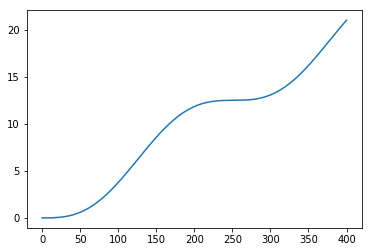

In [15]:
plt.plot(X[1, :])
plt.show()

In [16]:
import mosek.fusion
from mosek.fusion import Expr as expr

In [17]:
M = mosek.fusion.Model()

In [18]:
a = M.variable("a", 1)
b = M.variable("b", 1)

In [19]:
expr.vstack([a.asExpr(), b.asExpr()])

mosek.fusion.Expr

In [20]:
slack = M.variable("slack", 1)

states = []
for i in range(steps+1):
    states.append(M.variable("state"+str(i), 4))
    
forces = []
for i in range(steps):
    forces.append(M.variable("f"+str(i), 1))

In [21]:
slack_expr = slack.asExpr()
states_expr = [state.asExpr() for state in states]
forces_expr = [force.asExpr() for force in forces]

In [22]:
M.constraint("qcone", expr.vstack([slack_expr] + states_expr), mosek.fusion.Domain.inQCone())

mosek.fusion.ConicConstraint

In [23]:
M.constraint("starting value", states[0], mosek.fusion.Domain.equalsTo([0, 1, 0, 1]))

mosek.fusion.LinearConstraint

In [24]:
for i in range(steps):
    M.constraint("step"+str(i), expr.sub(expr.add(expr.mul(Ad, states[i]), expr.mul(Bd, forces[i])), states[i+1]), 
                 mosek.fusion.Domain.equalsTo(0))

In [25]:
M.objective("lqr", mosek.fusion.ObjectiveSense.Minimize, slack)

In [26]:
# position never below 0
#for state in states:
#    M.constraint(state.index(1), mosek.fusion.Domain.greaterThan(0))
#    M.constraint(state.index(3), mosek.fusion.Domain.greaterThan(0))

In [27]:
# forces never above 0.3
for force in forces:
    M.constraint(force, mosek.fusion.Domain.greaterThan(-0.3))
    M.constraint(expr.neg(force), mosek.fusion.Domain.greaterThan(-0.3))

In [28]:
M.solve()

In [29]:
slack.level()

array([9.1081253])

In [30]:
states_num = [state.level() for state in states]
states_num = np.array(states_num)

forces_num = [force.level() for force in forces]
forces_num = np.array(forces_num)

In [31]:
states_num.shape

(401, 4)

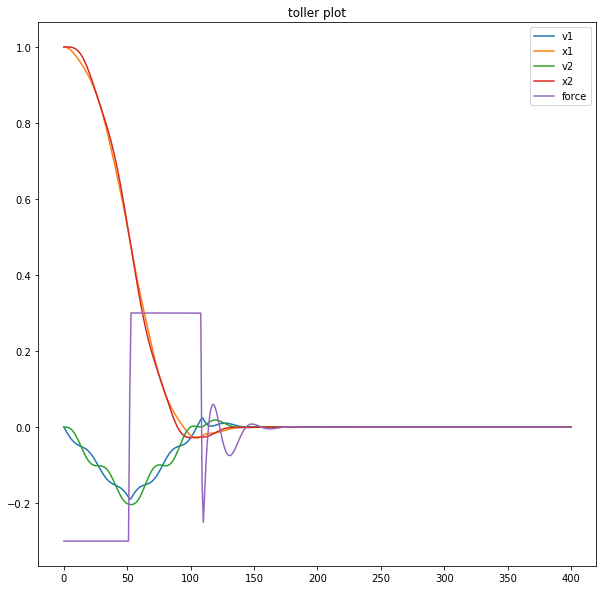

In [32]:
plt.figure(figsize=(10,10))
plt.title("toller plot")
plt.plot(states_num)
plt.plot(forces_num)
plt.legend(["v1", "x1", "v2", "x2", "force"])
plt.show()